# Direct Comparison of Quantum 3SAT algorithm and classical counterpart.  

## Shared functions/dependencies 

In [1]:
# Needed for functions
import time
import numpy as np
from numpy import pi
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import random
from QSAT import *
from Shonings import *
import multiprocessing
from multiprocessing import Process, Pool

#import packages for classical algorithm
import ctypes
from numpy import ctypeslib as npct

#import packages for quantum algorithm
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import qiskit.quantum_info as qi

from qiskit import Aer, transpile
# import qiskit.providers.aer
from qiskit_aer import AerError

from scipy.optimize import minimize


## Exhaustive search for solution

Helper functions for classical exhaustive search of solutions to SAT instance

In [2]:
def checkSAT(SAT, state, c, n):
        
    for t in range(c):
        # //get the variables the clause is interested in
        seive = (1 << (abs(int(SAT[t][0])) - 1)) + (1 << (int(abs(SAT[t][1])) - 1)) + (1 << (int(abs(SAT[t][2])) - 1))
        # //get the values in the clause to xor
        gate = 0
            
        if (SAT[t][0] > 0):
            gate += 1 << (abs(int((SAT[t][0]))) - 1)
        if (SAT[t][1] > 0):
            gate += 1 << (abs(int((SAT[t][1]))) - 1)
        if (SAT[t][2] > 0):
            gate += 1 << (abs(int((SAT[t][2]))) - 1)

        a = seive & state
        b = gate ^ a

        if (b == 0):
            return False
    return True

def exhausting(SAT,c,n):
    solutions = []
#     for t in range(c):
#         print((int(SAT[t][0]))," ",(int(SAT[t][1]))," ",(int(SAT[t][2])))
    
    for s in range(0,2**n):
        state = int(s)
        if(checkSAT(SAT, state, c, n)):
            solutions.append(state)
    return solutions
            

# Test and compare quantum and classical algorithms

In [3]:
def setup(n,nc,nSAT):
    par = {}
    par['nQ'] = n
    par['nC'] = nc
    par['nSAT'] = nSAT
    par['sat'] = buildSatSingleSolution(par['nQ'])
#     par['nC'] = len(par['sat'])
    par['satList'] = SATset(n,nc,nSAT)
    par['numRepeats'] = 10000000
    par['numIt'] = 1#nc
    par['maxIt'] = n**2
    
    #Plotting Conditionals
    par['latex'] = True
    par['statevector'] = True
    par['saveEnd'] = False
    par['figName'] = "plots/QAOASAT/{:0>3}.png".format(par['nQ'])
    par['xAsis'] = "$\frac{c}{v}$"
    par['yAsis'] = "$P(\text{solved})_{i<"+"+{}".format(par['maxIt'])+"}$"
    
    par['measure'] = False
    par['had'] = True
    
    par['gpu'] = False
    
    state = ''
    for q in range(n):
        state = state + '0'
    par['state'] = state
    
    return par

Initialize parameters for SAT instance

In [16]:
# cores = multiprocessing.cpu_count()
# pool = Pool(cores)
# print(cores)

n = 8
nc = int(n*(4.25))
# nc = 3
print(nc)
nsat = 1
par = setup(n,nc,nsat)
print(par['nQ'])

34
8


[0, 4, 6, 65, 132, 134, 150, 193]
Iteration 1 took -15.085331201553345
Total probability:0.2746931318288482


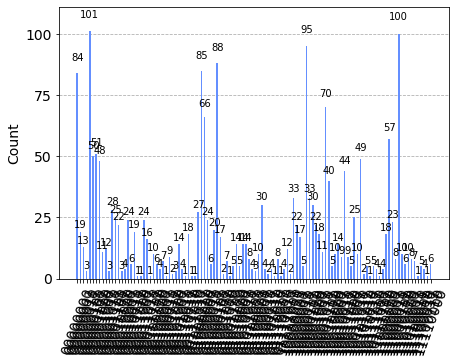

In [20]:
DM = 0
DM2= 0
l = 0
for sat in par['satList']:
    par['sat'] = sat
    
    solutions = exhausting(par['sat'],par['nC'],par['nQ'])
    print(solutions)
    
    #quantum run
#     maxIt = par['maxIt']#c#n**2
    par['numIt'] = 1
    entropyList = []
    entropyList2 = []
    probList = []

    it = 1
    
    if par['gpu']:
        # Initialize a GPU backend
        try:
            simulator_density_matrix = Aer.get_backend('aer_simulator_density_matrix')
            simulator_density_matrix.set_options(device='GPU')
        except AerError as e:
            print(e)

#         for it in xs:
        par['numIt']  = it
        shots = 100000

        # Build circuit
        start = time.time()
        qc = buildCircuitQFT3phase(par,True)
        circ = transpile(qc, simulator_density_matrix, optimization_level=0)
        job_density_matrix = simulator_density_matrix.run(circ, shots=shots)
        counts_density_matrix = job_density_matrix.result().get_counts(0)

        print("Iteration "+str(par['numIt'])+" took " + str(start-time.time()))
        print("counts_density_matrix: " + str(len(counts_density_matrix)))
        total = 0
        for state in counts_density_matrix:
            if(checkSAT(par['sat'], int(state, 2), len(par['sat']), par['nQ'])):
                total += counts_density_matrix[state]

        probList.append(total/shots)
        print("Total probability:" + str(total/shots))
        
    else:
#         for it in xs:
        par['numIt']  = it

        # Build circuit
        start = time.time()
        qc = buildCircuitQFT3phase(par,False)

        if(par['statevector']):
            # Execute and get counts
            DM = qi.DensityMatrix.from_instruction(qc)
            # probs = DM.probabilities_dict()
            DM2 = qi.partial_trace(DM,[par['nQ']])
            probs = DM2.probabilities_dict()
            entropyList.append(qi.entropy(DM2))

        print("Iteration " + str(it) + " took " + str(start-time.time()))

        names = list(probs.keys())
        values = list(probs.values())

        totalProb = 0
        for s in solutions:
            totalProb += list(probs.values())[s]
        probList.append(totalProb)
        print("Total probability:" + str(totalProb))
        
#         plt.plot(xs, entropyList, c='red')
    #     plt.plot(xs, entropyList2, c='magenta')
#         plt.show()
    l+=1
    
#     plt.rcParams['text.usetex'] = True
#     plt.rcParams["figure.figsize"] = (5,3)
#     plt.plot(base[:-1], cumulative, c='blue',label="ModSchonings")
#     plt.plot(baseS[:-1], cumulativeS, c='green',label="Schonings")
#     plt.plot(xs, probList, c='red',label="Q-SAT")
#     plt.axis([1,par['maxIt'],0,1])
#     plt.ylabel('$P_{solved}(i)$')
#     plt.xlabel('$i$')
#     plt.title('$n={n}$, $s={s}$'.format(n=par['nQ'],s=par['numRepeats']))
#     plt.legend()
#     plt.savefig('plots/hardProbs/phase-n{n}-s{s}-l{l}.png'.format(n=par['nQ'],s=par['numRepeats'],l=l),dpi=800)
# plot_state_city(DM2)
results = DM2.sample_counts(shots=2000)
plot_histogram(results)

# reg
[33, 49, 59, 63]
Iteration 1 took -0.4083404541015625
Total probability:0.37192920443020216
[42, 58]
Iteration 1 took -0.37767767906188965
Total probability:0.17545411457606666
[36]
Iteration 1 took -0.4062836170196533
Total probability:0.07360165397508438
[]
Iteration 1 took -0.4030156135559082
Total probability:0
[4]
Iteration 1 took -0.3383307456970215
Total probability:0.06596206314741464

# QFTNOT


# QFT3NOT 
[33, 49, 59, 63]
Iteration 1 took -0.8690974712371826
Total probability:0.20312499999999462
[42, 58]
Iteration 1 took -0.8085594177246094
Total probability:0.09374999999999747
[36]
Iteration 1 took -0.899674654006958
Total probability:0.015624999999999568
[]
Iteration 1 took -0.8587424755096436
Total probability:0
[4]
Iteration 1 took -0.7863390445709229
Total probability:0.12499999999999654

# QFTphase



# QFT3phase
[33, 49, 59, 63]
Iteration 1 took -0.8886513710021973
Total probability:0.2955294007751333
[42, 58]
Iteration 1 took -0.8107590675354004
Total probability:0.13258379749951318
[36]
Iteration 1 took -0.8864924907684326
Total probability:0.0769089554511834
[]
Iteration 1 took -0.9477629661560059
Total probability:0
[4]
Iteration 1 took -0.7768285274505615
Total probability:0.20311382839018893


# reg
[3]
Iteration 1 took -0.392902135848999
Total probability:0.049221889091830326
[18]
Iteration 1 took -0.3561406135559082
Total probability:0.05692061932054669
[8, 40]
Iteration 1 took -0.3968818187713623
Total probability:0.13919992802655046
[32]
Iteration 1 took -0.3535325527191162
Total probability:0.08151243970056597
[2, 43, 59]
Iteration 1 took -0.3967099189758301
Total probability:0.23384807692418694


# QFTNOT


# QFT3NOT 
[3]
Iteration 1 took -0.8610835075378418
Total probability:0.09374999999999743
[18]
Iteration 1 took -0.7834281921386719
Total probability:0.015624999999999561
[8, 40]
Iteration 1 took -0.8433220386505127
Total probability:0.34374999999999034
[32]
Iteration 1 took -0.8649649620056152
Total probability:0.046874999999998765
[2, 43, 59]
Iteration 1 took -0.8500561714172363
Total probability:0.2812499999999923

# QFTphase
[3]
Iteration 1 took -8.322554588317871
Total probability:0.07010888944840385
[18]
Iteration 1 took -8.368085384368896
Total probability:0.04346752870550419
[8, 40]
Iteration 1 took -8.309432744979858
Total probability:0.059996316836247655
[32]
Iteration 1 took -8.266597986221313
Total probability:0.07414195652992296
[2, 43, 59]
Iteration 1 took -8.295517206192017
Total probability:0.1855977835244083


# QFT3phase
[3]
Iteration 1 took -0.8604464530944824
Total probability:0.15753263007444318
[18]
Iteration 1 took -0.78584885597229
Total probability:0.0692074461911941
[8, 40]
Iteration 1 took -0.8611190319061279
Total probability:0.24894598571522603
[32]
Iteration 1 took -0.7809524536132812
Total probability:0.15564340400343163
[2, 43, 59]
Iteration 1 took -0.8526866436004639
Total probability:0.32444348513989724


$$
y_k=\frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} x_j \omega_N^{j k}, \quad \omega_N^{j k}=e^{2 \pi i \frac{j k}{N}}
$$

$$
y_k=\frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} x_j e^{2 \pi i \frac{j k}{N}}
$$

# reg
[4, 36, 41]
Iteration 1 took -0.3937222957611084
Total probability:0.22602439708682673
[15]
Iteration 1 took -0.4188377857208252
Total probability:0.07318754591312425
[3]
Iteration 1 took -0.40597963333129883
Total probability:0.05834680914162246
[]
Iteration 1 took -0.33884263038635254
Total probability:0
[3, 19]
Iteration 1 took -0.37379956245422363
Total probability:0.13638608627560722

# QFTNOT
[4, 36, 41]
Iteration 1 took -5.7821385860443115
Total probability:0.07812499999999577
[15]
Iteration 1 took -5.8723249435424805
Total probability:0.031249999999998227
[3]
Iteration 1 took -5.92201566696167
Total probability:0.031249999999998234
[]
Iteration 1 took -5.806966304779053
Total probability:0
[3, 19]
Iteration 1 took -6.231503486633301
Total probability:0.062499999999996475

# QFT3NOT 
[4, 36, 41]
Iteration 1 took -0.9201102256774902
Total probability:0.18749999999999475
[15]
Iteration 1 took -0.8708193302154541
Total probability:0.062499999999998265
[3]
Iteration 1 took -0.8492217063903809
Total probability:0.07812499999999785
[]
Iteration 1 took -0.7730591297149658
Total probability:0
[3, 19]
Iteration 1 took -0.804607629776001
Total probability:0.10937499999999697

# QFTphase
[4, 36, 41]
Iteration 1 took -8.161507368087769
Total probability:0.15900355210828124
[15]
Iteration 1 took -8.26687741279602
Total probability:0.07081040732341302
[3]
Iteration 1 took -8.340599060058594
Total probability:0.05897736146906482
[]
Iteration 1 took -8.233160018920898
Total probability:0
[3, 19]
Iteration 1 took -8.21707797050476
Total probability:0.19729466219169142


# QFT3phase
[4, 36, 41]
Iteration 1 took -0.901724100112915
Total probability:0.17745449702480548
[15]
Iteration 1 took -0.8740053176879883
Total probability:0.09226886472079991
[3]
Iteration 1 took -0.8478865623474121
Total probability:0.048361179623812534
[]
Iteration 1 took -0.7726542949676514
Total probability:0
[3, 19]
Iteration 1 took -0.8055250644683838
Total probability:0.171751347823925

Run statistical test of modified Shonings algorithm

In [8]:

l = 0
for sat in par['satList']:
    par['sat'] = sat
    
    #   Run statistical test of modified Shonings algorithm
    start = time.time()
    result = []
    for c in range(cores):
        result.append(pool.apply_async(classicalSolve,args=(par['nQ'],par['sat'],par['nC'],par['maxIt'],int(par['numRepeats']/cores))))
    results = [ar.get() for ar in result]
    cutoff=[item for sublist in results for item in sublist if item <= par['maxIt']]
    # cutoff = [x for x in res if x <= par['maxIt']]
    values, base = np.histogram(cutoff, bins=par['maxIt'], range=(1,par['maxIt']+1))
    # values, base = np.histogram(res, bins=n**2)
    #evaluate the cumulative
    cumulative = np.cumsum(values)/par['numRepeats']
    print(cumulative)
    print(time.time()-start)
    
    start = time.time()
    # resS = classicalSolveS(par['nQ'],par['sat'],par['nC'],par['maxIt'],par['numRepeats'])
    # cutoffS = [x for x in resS if x <= par['maxIt']]
    result = []
    for c in range(cores):
        result.append(pool.apply_async(classicalSolveS,args=(par['nQ'],par['sat'],par['nC'],par['maxIt'],int(par['numRepeats']/cores))))
    results = [ar.get() for ar in result]
    cutoffS=[item for sublist in results for item in sublist if item <= par['maxIt']]
    # cutoff = [x for x in res if x <= par['maxIt']]
    valuesS, baseS = np.histogram(cutoffS, bins=par['maxIt'], range=(1,par['maxIt']+1))
    # valuesS, baseS = np.histogram(resS, bins=n**2)
    #evaluate the cumulative
    cumulativeS = np.cumsum(valuesS)/par['numRepeats']
    print(cumulativeS)
    print(time.time()-start)
    
    solutions = exhausting(par['sat'],par['nC'],par['nQ'])
    print(solutions)
    
    #quantum run
    maxIt = par['maxIt']#c#n**2

    entropyList = []
    entropyList2 = []
    probList = []

    xs = np.linspace(1,maxIt,num = maxIt,dtype='int',endpoint=True)
    # par['sat'] = par['satList'][0]
    if par['gpu']:
        # Initialize a GPU backend
        # Note that the cloud instance for tutorials does not have a GPU
        # so this will raise an exception.
        try:
            simulator_density_matrix = Aer.get_backend('aer_simulator_density_matrix')
    #         simulator_density_matrix = Aer.get_backend('aer_simulator_statevector')
            simulator_density_matrix.set_options(device='GPU')
    #         config = simulator_density_matrix.configuration()
    #         print(str(config.multi_meas_enabled))
        except AerError as e:
            print(e)

        for it in xs:
            par['numIt']  = it
            shots = 100000

            # Build circuit
            start = time.time()
            qc = buildCircuit(par,True)
            circ = transpile(qc, simulator_density_matrix, optimization_level=0)
            job_density_matrix = simulator_density_matrix.run(circ, shots=shots)
            counts_density_matrix = job_density_matrix.result().get_counts(0)

            print("Iteration " + str(it) + " took " + str(start-time.time()))

            total = 0
            for state in counts_density_matrix:
                if(checkSAT(par['sat'], int(state, 2), len(par['sat']), par['nQ'])):
                    total += counts_density_matrix[state]

            probList.append(total/shots)
    else:
        for it in xs:
            par['numIt']  = it

            # Build circuit
            start = time.time()
            qc = buildCircuit(par,False)

            if(par['statevector']):
                # Execute and get counts
                DM = qi.DensityMatrix.from_instruction(qc)
                # probs = DM.probabilities_dict()
                DM2 = qi.partial_trace(DM,[par['nQ']])
                probs = DM2.probabilities_dict()
                entropyList.append(qi.entropy(DM2))

            print("Iteration " + str(it) + " took " + str(start-time.time()))

            names = list(probs.keys())
            values = list(probs.values())

            totalProb = 0
            for s in solutions:
                totalProb += list(probs.values())[s]
            probList.append(totalProb)

        plt.plot(xs, entropyList, c='red')
    #     plt.plot(xs, entropyList2, c='magenta')
#     plt.show()
    l+=1
    
    plt.rcParams['text.usetex'] = True
    plt.rcParams["figure.figsize"] = (5,3)
    plt.plot(base[:-1], cumulative, c='blue',label="ModSchonings")
    plt.plot(baseS[:-1], cumulativeS, c='green',label="Schonings")
    plt.plot(xs, probList, c='red',label="Q-SAT")
    plt.axis([1,par['maxIt'],0,1])
    plt.ylabel('$P_{solved}(i)$')
    plt.xlabel('$i$')
    plt.title('$n={n}$, $s={s}$'.format(n=par['nQ'],s=par['numRepeats']))
    plt.legend()
    plt.savefig('plots/hardProbs/phase-n{n}-s{s}-l{l}.png'.format(n=par['nQ'],s=par['numRepeats'],l=l),dpi=800)
    plt.show()

NameError: name 'cores' is not defined

Run statistical test of regular Shonings algorithm

[0.        0.        0.0264754 0.0264754 0.0264754 0.0264754 0.0264754
 0.0264754 0.0747852 0.0747852 0.0747852 0.0747852 0.0747852 0.0747852
 0.1177911 0.1177911 0.1177911 0.138726  0.1595088 0.1595088 0.1793826
 0.1928022 0.2108267 0.2304858 0.2304858 0.2688677 0.2688677 0.2871936
 0.3057372 0.3241254 0.3600526 0.3600526 0.3600526 0.3600526 0.3600526
 0.3770287 0.3770287 0.3932155 0.3932155 0.4090372 0.4090372 0.4252504
 0.4563596 0.4563596 0.4720806 0.4864702 0.5170554 0.5170554 0.5312774
 0.5312774 0.5463911 0.5738074 0.5738074 0.5738074 0.5874167 0.5874167
 0.6003259 0.6003259 0.6003259 0.6003259 0.6003259 0.6134621 0.6390049
 0.6517554 0.6641649 0.6766326 0.6766326 0.6766326 0.6766326 0.6766326
 0.6766326 0.6766326 0.6766326 0.7002964 0.7117234 0.7117234 0.7230596
 0.7230596 0.7230596 0.7343958 0.7343958 0.7343958 0.7343958 0.7455338
 0.7455338 0.7564486 0.7564486 0.7674033 0.7784852 0.7889469 0.7889469
 0.7889469 0.7889469 0.7889469 0.7889469 0.7889469 0.7889469 0.7889469
 0.799

In [7]:

# print(par['satList'][0])

[7]


[[-4, -3, -2], [-4, -3, 2], [-4, -2, -1], [-4, -2, 1], [-4, -1, 2], [-4, -1, 3], [-4, 1, 3], [-3, -2, 1], [-2, -1, 3], [-2, -1, 4], [-2, 1, 3], [-2, 1, 4], [1, 2, 3], [1, 2, 4], [1, 3, 4], [2, 3, 4]]

Run test of quantum algorithm

Iteration 1 took -1.871645450592041
Iteration 2 took -2.839872121810913
Iteration 3 took -3.6732327938079834
Iteration 4 took -4.803991317749023
Iteration 5 took -6.0568459033966064
Iteration 6 took -7.148922443389893
Iteration 7 took -8.226903200149536
Iteration 8 took -9.31818151473999
Iteration 9 took -10.418678522109985
Iteration 10 took -11.880117177963257
Iteration 11 took -13.079850912094116
Iteration 12 took -14.041352033615112
Iteration 13 took -15.768455505371094
Iteration 14 took -16.70793390274048
Iteration 15 took -18.26339316368103
Iteration 16 took -18.87366819381714
Iteration 17 took -20.2901873588562
Iteration 18 took -21.243782997131348
Iteration 19 took -22.381351709365845
Iteration 20 took -23.896066904067993
Iteration 21 took -24.612643003463745
Iteration 22 took -26.116811990737915
Iteration 23 took -26.927981853485107
Iteration 24 took -28.160685062408447
Iteration 25 took -29.56934404373169
Iteration 26 took -30.237140417099
Iteration 27 took -31.72738528251648


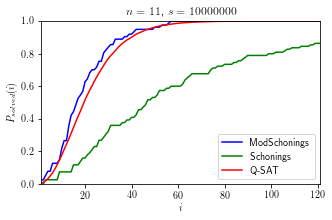

In [9]:
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (5,3)
plt.plot(base[:-1], cumulative, c='blue',label="ModSchonings")
plt.plot(baseS[:-1], cumulativeS, c='green',label="Schonings")
plt.plot(xs, probList, c='red',label="Q-SAT")
plt.axis([1,par['maxIt'],0,1])
plt.ylabel('$P_{solved}(i)$')
plt.xlabel('$i$')
plt.title('$n={n}$, $s={s}$'.format(n=par['nQ'],s=par['numRepeats']))
plt.legend()
plt.savefig('plots/singleSolution/singleSolution-n{n}-s{s}.png'.format(n=par['nQ'],s=par['numRepeats']),dpi=800)
plt.show()

In [14]:
print("Number of cpu : ", multiprocessing.cpu_count())

Number of cpu :  16


In [11]:
maxIt = par['maxIt']#c#n**2

probListGamma = []
xs = np.linspace(1,maxIt,num = maxIt,dtype='int')
par['sat'] = par['satList'][0]
gammaList = np.linspace(0,2*np.pi,num = 6,dtype='float')

for g in range(len(gammaList)):
    probListGamma.append([]) 

# print(gammaList)
for it in xs:
    par['numIt']  = it
    for g in range(len(gammaList)):
        par['gamma'] = 0
        par['beta'] = gammaList[g]
        qc2 = buildCircuitCost(par,False)
        totalProb = 0
        for s in solutions:
            totalProb += list(probs.values())[s]
        probList.append(totalProb)

        if(par['statevector']):
            # Execute and get counts
            DM2 = qi.DensityMatrix.from_instruction(qc2)
            # probs = DM.probabilities_dict()
            DM22 = qi.partial_trace(DM2,[par['nQ']])
            probs2 = DM22.probabilities_dict()

        print("Iteration " + str(it) + " took " + str(start-time.time()))

        names2 = list(probs2.keys())
        values2 = list(probs2.values())

        totalProb2 = 0
        for s in solutions:
            totalProb2 += probs2[f'{s:04b}']
        probListGamma[g].append(totalProb2)
      

    
for li in range(len(probListGamma)):
    name = "QAOA g="+ str(gammaList[li])
    plt.plot(xs, probListGamma[li] ,label=name)
    
plt.legend()

NameError: name 'probs' is not defined

In [36]:
def toMin2(phases):
    probList3 = []
        
    par['gamma'] = phases[0]
    par['beta'] = phases[1]
#     par['numIt']  = phases[2]

    qc2 = buildCircuitCost(par,False)
    totalProb = 0
    for s in solutions:
        totalProb += list(probs.values())[s]
    probList.append(totalProb)

    if(par['statevector']):
        # Execute and get counts
        DM2 = qi.DensityMatrix.from_instruction(qc2)
        # probs = DM.probabilities_dict()
        DM22 = qi.partial_trace(DM2,[par['nQ']])
        probs2 = DM22.probabilities_dict()
        entropyList2.append(qi.entropy(DM22))

#     print("Iteration " + str(it) + " took " + str(start-time.time()))

    names2 = list(probs2.keys())
    values2 = list(probs2.values())
#         print(names2)
#         print(values2)

    totalProb2 = 0
#         print(solutions)
    for s in solutions:
#             print(s)
        totalProb2 += probs2[f'{s:04b}']
#     probList2.append(totalProb2)

    return 1 - totalProb2

In [37]:
par = setup(4,16,1)

[1. 1.]
[1. 1.]
[1. 1.]
[2. 1.]
[2. 2.]
[2. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[2. 1.]
[2. 1.]
[2. 1.]
[2. 2.]
[1. 2.]
[1. 1.]
Iteration 1 took -1317.5180518627167
Iteration 1 took -1317.5247149467468
Iteration 1 took -1317.531564950943
Iteration 1 took -1317.5381903648376
Iteration 1 took -1317.5449047088623
Iteration 1 took -1317.551561832428
Iteration 1 took -1317.5582447052002
Iteration 1 took -1317.5648806095123
Iteration 1 took -1317.571655511856
Iteration 1 took -1317.5784933567047
Iteration 1 took -1317.5851809978485
Iteration 1 took -1317.5918655395508
Iteration 1 took -1317.5985162258148
Iteration 1 took -1317.605138540268
Iteration 1 took -1317.6118235588074
Iteration 1 took -1317.6185817718506
Iteration 1 took -1317.6252179145813
Iteration 2 took -1317.6695535182953
Iteration 2 took -1317.6809396743774
Iteration 2 took -1317.6924459934235
Iteration 2 took -1317.7053680419922
Iteration 2 took -1317.7171604633331
Iteration 2 took -1317.728464126587
Iteration 2 took -1317.739

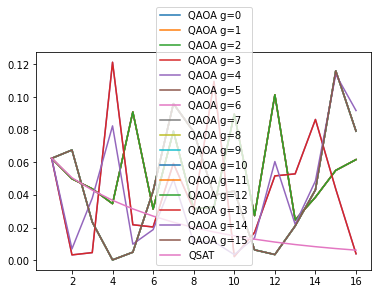

In [38]:
maxIt = par['maxIt']#c#n**2

probListGamma = []
probList2 = []
xs = np.linspace(1,maxIt,num = maxIt,dtype='int')
# par['sat'] = par['satList'][0]
# gammaList = np.linspace(0,2*np.pi,num = 6,dtype='float')

for g in range(maxIt):
    probListGamma.append([]) 
    
phaseList = []
gammaList = []
for g in range(maxIt):
    gammaList.append(g)
    par['numIt'] = g
    sendIt = [1.0,1.0]
    res = minimize(toMin2,sendIt,method='COBYLA',options={'disp': True, 'maxiter':3})
    phaseList.append(res.x)
    print(res.x)
an = par['nQ']
# print(gammaList)
for it in xs:
    start = time.time()
    par['numIt']  = it
    
#     shots = 10000 

    qc2 = buildCircuit(par,False)

    if(par['statevector']):
        # Execute and get counts
        DM2 = qi.DensityMatrix.from_instruction(qc2)
        # probs = DM.probabilities_dict()
        DM22 = qi.partial_trace(DM2,[par['nQ']])
        probs2 = DM22.probabilities_dict()

    

    names2 = list(probs2.keys())
    values2 = list(probs2.values())

    totalProb2 = 0
    
    for s in solutions:
        totalProb2 += probs2[f'{s:>{an}b}']
    probList2.append(totalProb2)
    
    for g in range(maxIt):
        
        par['gamma'] = phaseList[g][0]
        par['beta'] = phaseList[g][1]
        
        
        qc2 = buildCircuitCost(par,False)
#         totalProb = 0
#         for s in solutions:
#             totalProb += list(probs.values())[s]
#         probList.append(totalProb)

        if(par['statevector']):
            # Execute and get counts
            DM2 = qi.DensityMatrix.from_instruction(qc2)
            # probs = DM.probabilities_dict()
            DM22 = qi.partial_trace(DM2,[par['nQ']])
            probs2 = DM22.probabilities_dict()

#         

        names2 = list(probs2.keys())
        values2 = list(probs2.values())

        totalProb2 = 0
        for s in solutions:
            totalProb2 += probs2[f'{s:>{an}b}']
        probListGamma[g].append(totalProb2)
      
    print("Iteration " + str(it) + " took " + str(start-time.time()))
    
for li in range(len(probListGamma)):
    name = "QAOA g="+ str(gammaList[li])
    plt.plot(xs, probListGamma[li] ,label=name)
    
print(len(probList2))
plt.plot(xs, probList2 ,label="QSAT")
    

    
plt.legend()

In [14]:
def toMin(phases):
    probList3 = []
    # Initialize a GPU backend
    # Note that the cloud instance for tutorials does not have a GPU
    # so this will raise an exception.
    try:
        simulator_density_matrix = Aer.get_backend('aer_simulator_density_matrix')
#         simulator_density_matrix = Aer.get_backend('aer_simulator_statevector')
        simulator_density_matrix.set_options(device='GPU')
#         config = simulator_density_matrix.configuration()
#         print(str(config.multi_meas_enabled))
    except AerError as e:
        print(e)
        
    par['gamma'] = phases[0]
    par['beta'] = phases[1]
    par['numIt']  = 6
    shots = 10000

#     # Build circuit
#     start = time.time()
#     qc = buildCircuit(par,True)
#     circ = transpile(qc, simulator_density_matrix, optimization_level=0)
#     job_density_matrix = simulator_density_matrix.run(circ, shots=shots)
#     counts_density_matrix = job_density_matrix.result().get_counts(0)

#     print("Iteration " + str(it) + " took " + str(start-time.time()))

#     total = 0
#     for state in counts_density_matrix:
#         if(checkSAT(par['sat'], int(state, 2), len(par['sat']), par['nQ'])):
#             total += counts_density_matrix[state]

#     probList.append(total/shots)

    # Build circuit
#     start = time.time()
#     qc2 = buildCircuitMeasure(par,True)
#     circ2 = transpile(qc2, simulator_density_matrix, optimization_level=0)
#     job_density_matrix2 = simulator_density_matrix.run(circ2, shots=shots)#,dynamic=True
#     counts_density_matrix2 = job_density_matrix2.result().get_counts(0)

#     print("Iteration " + str(it) + " took " + str(start-time.time()))
# #         print(counts_density_matrix2)
#     total2 = 0
#     for state in counts_density_matrix2:
# #             print(state)
#         if(checkSAT(par['sat'], int(state, 2), len(par['sat']), par['nQ'])):
#             total2 += counts_density_matrix2[state]

#     probList2.append(total2/shots)

    # Build circuit
    start = time.time()
    qc3 = buildCircuitCost(par,True)
    circ3 = transpile(qc3, simulator_density_matrix, optimization_level=0)
    job_density_matrix3 = simulator_density_matrix.run(circ3, shots=shots)#,dynamic=True
    counts_density_matrix3 = job_density_matrix3.result().get_counts(0)

    print("Iteration cost" + str(it) + " took " + str(start-time.time()))
#         print(counts_density_matrix2)
    total3 = 0
    for state in counts_density_matrix3:
#             print(state)
        if(checkSAT(par['sat'], int(state, 2), len(par['sat']), par['nQ'])):
            total3 += counts_density_matrix3[state]

    return 1 - total3/shots

In [ ]:
sendIt = [1.0,1.0]
res = minimize(toMin2,sendIt,method='COBYLA')
print(res.x)
print(sendIt)

In [ ]:
print(probList[-1])

In [ ]:
plt.plot(base[:-1]+1, cumulative/numIt, c='blue')
plt.plot(baseS[:-1]+1, cumulativeS/numIt, c='green')
plt.plot(xs, probList, c='red')
plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.plot(base[:-1]+1, cumulative/numIt, c='blue')
plt.plot(baseS[:-1]+1, cumulativeS/numIt, c='green')
plt.plot(xs, probList, c='red')
plt.xscale('log')